# Multi-Modal Deep Learning for Sentiment Analysis of Internet Memes

In [38]:
# Importing necessary modules

import os
import re
import nltk
import random
import zipfile
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from keras.models import Model
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image, ImageFile
from keras.optimizers import SGD, Adam
from nltk.corpus import stopwords
from keras.layers import Embedding
from matplotlib.image import imread
ImageFile.LOAD_TRUNCATED_IMAGES = True
from ekphrasis.dicts.emoticons import emoticons
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.classes.preprocessor import TextPreProcessor
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Concatenate, Bidirectional, GlobalMaxPooling1D
from sklearn.metrics import precision_recall_curve, auc, precision_score, recall_score, f1_score

Unzipping the Dataset

In [39]:
# Unzip the kaggle memotion archive

dataset_path = '/Users/praharshmedisetty/Documents/Visual_Studio/archive.zip'
folder = '/Users/praharshmedisetty/Documents/Visual_Studio/Extracted'

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(folder)

Dataset Text and Images Visualization

In [122]:
# Load the labels text dataset and visualize it

df = pd.read_csv("/Users/praharshmedisetty/Documents/Visual_Studio/Extracted/memotion_dataset_7k/labels.csv")
df.head(10)

Unnamed: 0    image_name  \
0           0   image_1.jpg   
1           1  image_2.jpeg   
2           2   image_3.JPG   
3           3   image_4.png   
4           4   image_5.png   
5           5   image_6.jpg   
6           6   image_7.png   
7           7   image_8.jpg   
8           8   image_9.jpg   
9           9  image_10.png   

                                            text_ocr  \
0  LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...   
1  The best of #10 YearChallenge! Completed in le...   
2  Sam Thorne @Strippin ( Follow Follow Saw every...   
3              10 Year Challenge - Sweet Dee Edition   
4  10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...   
5  1998: "Don't get in car with strangers" 2008: ...   
6  10 years challenge is lit af Üs & B erg 1945 1...   
7  10 Year Challenge emotional edition boredpanda...   
8  Fornite died in 10 months but Minecraft never ...   
9  FACEBOOK '10 YEAR CHALLENGE': A PLOY OR A SIMP...   

                                      text_corrected      humour  \
0  LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...   hilarious   
1  The best of #10 YearChallenge! Completed in le...   not_funny   
2  Sam Thorne @Strippin ( Follow Follow Saw every...  very_funny   
3              10 Year Challenge - Sweet Dee Edition  very_funny   
4  10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...   hilarious   
5  1998: "Don't get in car with strangers" 2008: ...   hilarious   
6  10 years challenge is lit af Üs & B erg 1945 1...   not_funny   
7  10 Year Challenge emotional edition boredpanda...  very_funny   
8  Fornite died in 10 months but Minecraft never ...       funny   
9  FACEBOOK '10 YEAR CHALLENGE': A PLOY OR A SIMP...       funny   

           sarcasm       offensive      motivational overall_sentiment  
0          general   not_offensive  not_motivational     very_positive  
1          general   not_offensive      motivational     very_positive  
2    not_sarcastic   not_offensive  not_motivational          positive  
3  twisted_meaning  very_offensive      motivational          positive  
4     very_twisted  very_offensive  not_motivational           neutral  
5          general          slight      motivational          negative  
6    not_sarcastic   not_offensive  not_motivational          negative  
7  twisted_meaning   not_offensive  not_motivational           neutral  
8    not_sarcastic          slight      motivational          positive  
9          general          slight      motivational          positive

In [123]:
# Labels CSV dataset statistics before preprocessing

rows, columns = df.shape
print(f"\nRows:{rows}")
print(f"Columns:{columns}\n")

print('Dataset Information:\n')
df.info()

print('\nDataset Description')
df.describe()


Rows:6992
Columns:9

Dataset Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6992 entries, 0 to 6991
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         6992 non-null   int64 
 1   image_name         6992 non-null   object
 2   text_ocr           6831 non-null   object
 3   text_corrected     6987 non-null   object
 4   humour             6992 non-null   object
 5   sarcasm            6992 non-null   object
 6   offensive          6992 non-null   object
 7   motivational       6992 non-null   object
 8   overall_sentiment  6992 non-null   object
dtypes: int64(1), object(8)
memory usage: 491.8+ KB

Dataset Description


Unnamed: 0
count  6992.000000
mean   3495.500000
std    2018.560873
min       0.000000
25%    1747.750000
50%    3495.500000
75%    5243.250000
max    6991.000000

In [42]:
# Converting all images to .png format for consistency

input_directory = "/Users/praharshmedisetty/Documents/Visual_Studio/Extracted/memotion_dataset_7k/images"
output_directory = "/Users/praharshmedisetty/Documents/Visual_Studio/Extracted/memotion_dataset_7k/images"

for filename in os.listdir(input_directory):
    input_path = os.path.join(input_directory, filename)
    img = Image.open(input_path)
    img = img.convert("RGB")
    output_path = os.path.join(output_directory, os.path.splitext(filename)[0] + ".png")
    img.save(output_path, "PNG")

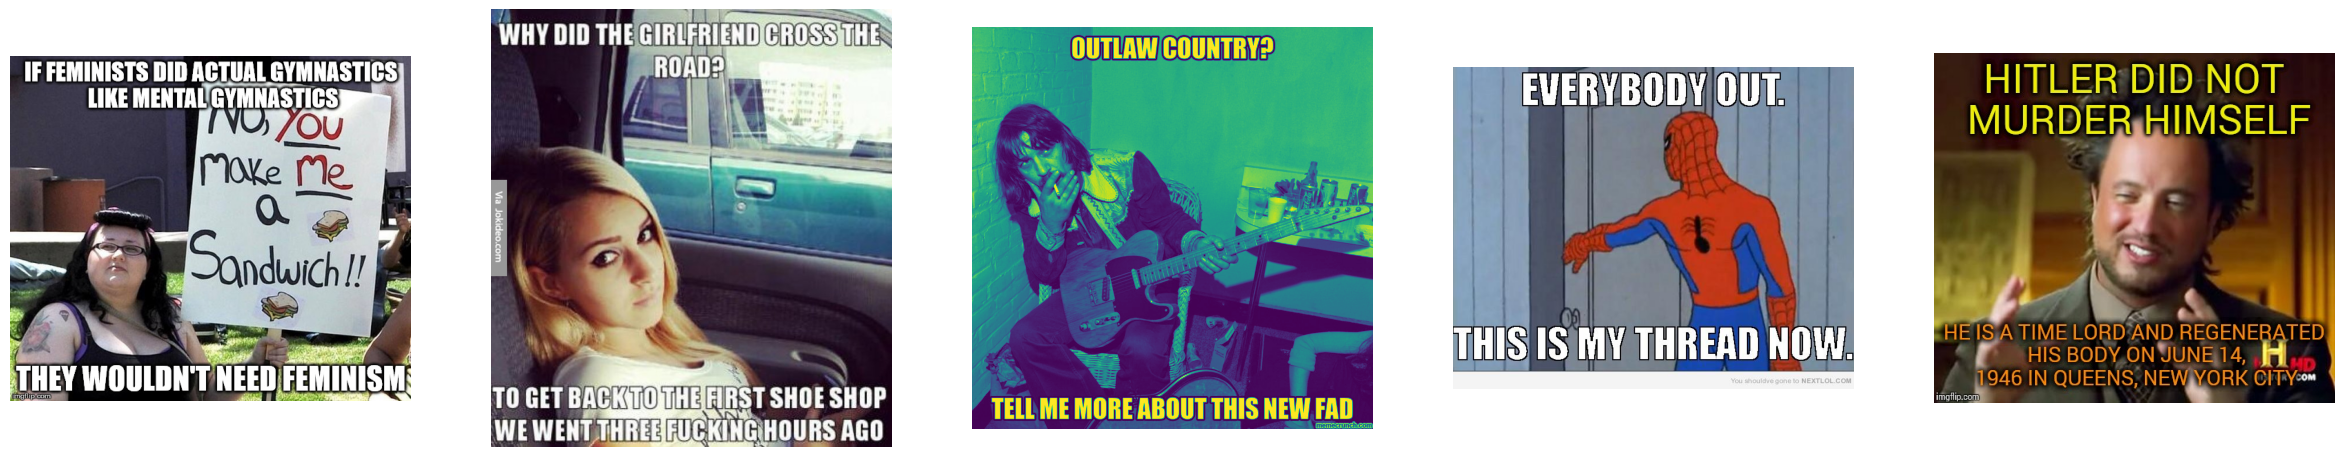

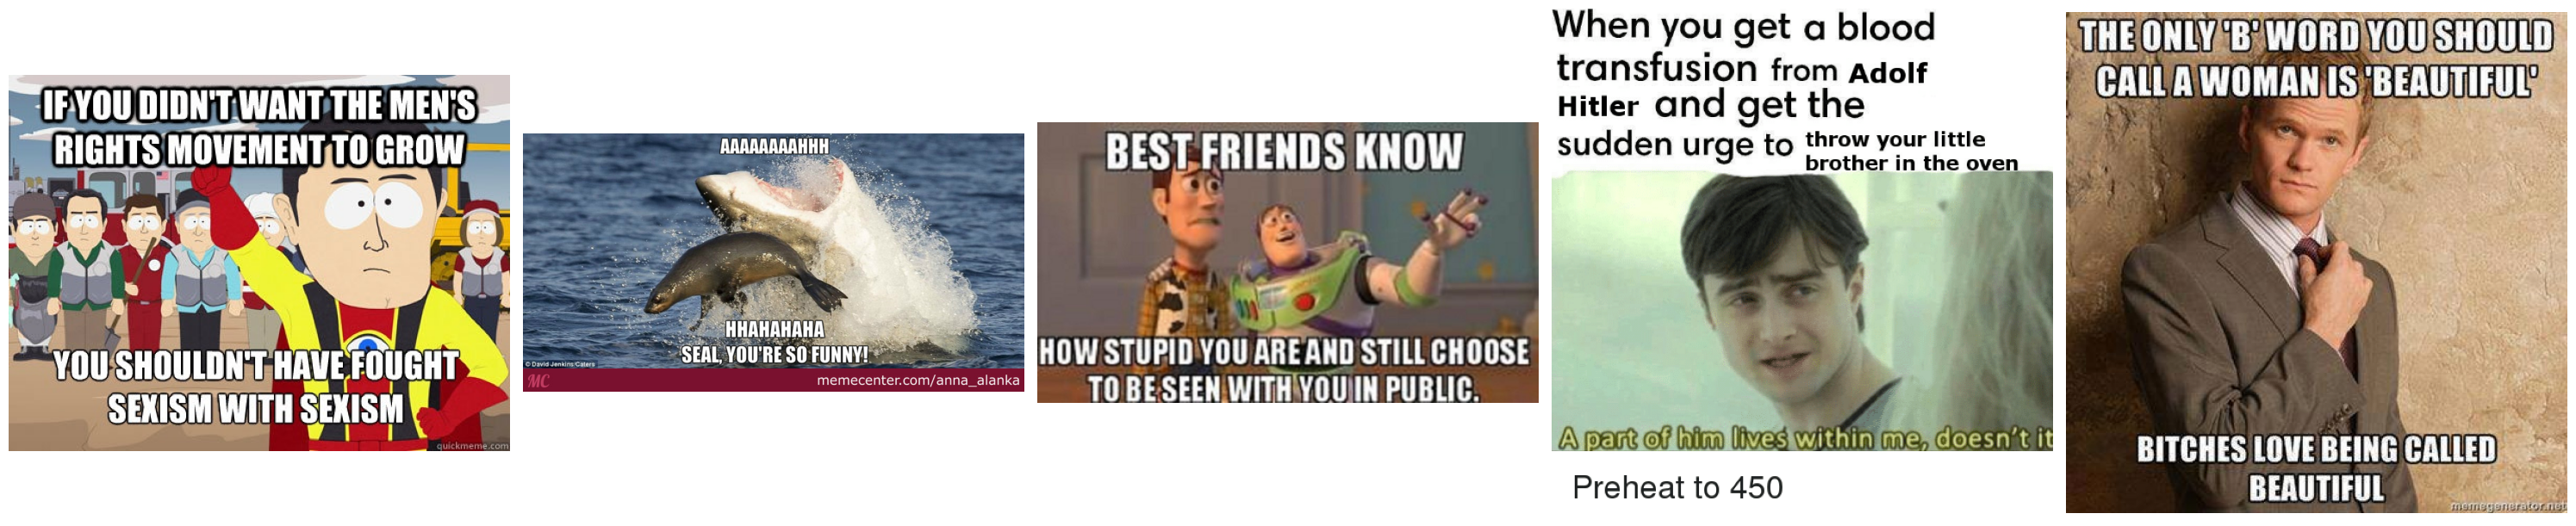

In [43]:
# Visualizing the 'images' (Memes) dataset

image_path = '/Users/praharshmedisetty/Documents/Visual_Studio/Extracted/memotion_dataset_7k/images'
num_img = 5
num_img_per_row = 2

for i in range(num_img_per_row):
    img_file_name = os.listdir(image_path)
    cols = num_img
    rows = 1
    plt.figure(figsize=(30, 30))

    for i in range(num_img):
        rand_img = random.choice(img_file_name)
        rand_img_path = os.path.join(image_path, rand_img)
        img = imread(rand_img_path)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis('off')

plt.tight_layout()
plt.show()

Preprocessing the dataset

In [44]:
# downloading stopwords from nltk module
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/praharshmedisetty/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
# Function to remove stopwords
def remove_stopwords(text):
    text_data = text.split()
    text_data = [word for word in text_data if word not in stop_words]
    return ' '.join(text_data)

In [46]:
# Function to convert chat words
f = open("/Users/praharshmedisetty/Documents/Visual_Studio/slang.txt", "r")
chat_words_str = f.read()
chat_words_map_dict = {}
chat_words_list = []

for line in chat_words_str.split("\n"):
    # condition to check if the text line contains '='
    if "=" in line:
        cw = line.split("=")[0]
        cw_expanded = line.split("=")[1]
        chat_words_list.append(cw)
        chat_words_map_dict[cw] = cw_expanded
chat_words_list = set(chat_words_list)

def chat_words_conversion(text):
    new_text = []
    for word in text.split():
        if word.upper() in chat_words_list:
            new_text.append(chat_words_map_dict[word.upper()])
        else:
            new_text.append(word)
    return " ".join(new_text)

In [47]:
# Function to convert emoticons
from emoticons import EMOTICONS

def convert_emoticons(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', " ".join(EMOTICONS[emot].replace(",","").split()), text)
    return text

In [48]:
# Initialize Ekphrasis text processor
text_processor = TextPreProcessor(
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user', 'time', 'date', 'number'],  # Normalization preprocessing
    annotate={"hashtag", "allcaps", "elongated", "repeated", 'emphasis', 'censored'},  # Annotation preprocessing
    fix_html=True,  # preprocessing HTML tokens
    segmenter="twitter",  # Word segmentation preprocessing
    corrector="twitter",  # Spell correction preprocessing
    unpack_hashtags=True,  # preprocessing word segmentation on hashtags
    unpack_contractions=True,  # Unpack contraction words
    spell_correct_elong=True,  # Spell correction for elongated words
    tokenizer=SocialTokenizer(lowercase=True).tokenize,  # Tokenizer
    dicts=[emoticons]  # dictionaries for token replacement
)

Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


In [49]:
# Function to clean the raw text data
def preprocess_text(text):

    if not isinstance(text, str):
        return ""
    
    # convert string to lower
    text = text.lower()

    # Use the defined Ekphrasis pipeline for preprocessing
    text = " ".join(text_processor.pre_process_doc(text))
    
    # removing special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # removing punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # remove stopwords
    text = remove_stopwords(text)
    
    # remove extra whitespaces
    text = re.sub(r"\s+", " ", text).strip()

    # removing '.com' if any in the text
    text = re.sub(r'.com', '', text)
    
    # Convert chat words
    text = chat_words_conversion(text)

    # Convert emoticons
    text = convert_emoticons(text)
    
    return text

In [50]:
df = pd.read_csv("/Users/praharshmedisetty/Documents/Visual_Studio/Extracted/memotion_dataset_7k/labels.csv", header=None, skiprows=1)

# Split the data into training and validation sets
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)

# Text arrays and image paths
text_train = df_train[3]
text_val = df_val[3]
image_path_train = df_train[1]
image_path_val = df_val[1]

In [51]:
# Apply text preprocessing to training and validation text arrays
processed_text_train = [preprocess_text(text) for text in text_train]
processed_text_val = [preprocess_text(text) for text in text_val]

print("Length of Preprocessed Training Text Array:", len(processed_text_train))
print("\nLength of Preprocessed Validation Text Array:", len(processed_text_val))
print("\nImages in Training set:", len(image_path_train))
print("\nImages in Validation set:", len(image_path_val))

Length of Preprocessed Training Text Array: 5593

Length of Preprocessed Validation Text Array: 1399

Images in Training set: 5593

Images in Validation set: 1399


In [52]:
# preprocessing the images (image augmentation)
os.chdir(image_path)
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize_with_pad(img, 224, 224) # resizing image size to 224x224 for ResNet
    img = tf.keras.applications.resnet50.preprocess_input(img) # ResNet preprocessing
    return img, image_path

# Using ResNet50 model for feature extraction
resnet_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', pooling='max')
new_input = resnet_model.input
hidden_layer = resnet_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [53]:
# Get '.npy' of all images for image encodings

train_data = "/Users/praharshmedisetty/Documents/Visual_Studio/train_data"
if not os.path.exists(train_data):
    os.makedirs(train_data)

encode_train = sorted(set(df[1]))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)

  print(np.shape(batch_features))
  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save("/Users/praharshmedisetty/Documents/Visual_Studio/train_data/"+path_of_feature, bf.numpy())

print("\n\nAll Images converted to PNG format for consistency")

In [54]:
# Loading image encodings for training data
def map_func(img_name):
    encoding = np.load("/Users/praharshmedisetty/Documents/Visual_Studio/train_data/" + img_name + '.npy')
    return np.asarray(encoding)

# Loading image encodings for training data
image_encodings_train = np.zeros((len(image_path_train), 2048))
for index, img_path in enumerate(image_path_train):
    if index % 1 == 0:
        print(f"\r{index}th training entry performed",end=' ')
    image_encodings_train[index] = map_func(img_path)

print("\n\nImages after getting encoded from resnet for training data:")
print(np.shape(image_encodings_train))
print('\n')
# Loading image encodings for validation data
image_encodings_val = np.zeros((len(image_path_val), 2048))
for index, img_path in enumerate(image_path_val):
    if index % 1 == 0:
        print(f"\r{index}th validation entry performed", end=' ')
    image_encodings_val[index] = map_func(img_path)

print("\n\nImages after getting encoded from resnet for validation data:")
print(np.shape(image_encodings_val))

5592th training entry performed 

Images after getting encoded from resnet for training data:
(5593, 2048)


1398th validation entry performed 

Images after getting encoded from resnet for validation data:
(1399, 2048)


In [55]:
# Printing the sizes of processed text arrays and image encodings
print("Size of Preprocessed Training Text Array: " + str(len(processed_text_train)))
print("\nSize of Preprocessed Validation Text Array: " + str(len(processed_text_val)))
print("\nSize of Training Image Encodings: " + str(np.shape(image_encodings_train)))
print("\nSize of Validation Image Encodings: " + str(np.shape(image_encodings_val)))

Size of Preprocessed Training Text Array: 5593

Size of Preprocessed Validation Text Array: 1399

Size of Training Image Encodings: (5593, 2048)

Size of Validation Image Encodings: (1399, 2048)


In [56]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map, words

# GloVe file reference: https://www.kaggle.com/datasets/bertcarremans/glovetwitter27b100dtxt
# Call the function to load GloVe vectors
word_to_index, index_to_word, word_to_vec_map, vocab = read_glove_vecs('/Users/praharshmedisetty/Documents/Visual_Studio/glove.twitter.27B.100d.txt')

In [57]:
# Count of each label in dataset
def count_labels(data):
    # Count labels for overall sentiment, humour, sarcasm, offensive, motivate
    sentiment_overall = np.asarray(data[8])
    sentiment_humour = np.asarray(data[4])
    sentiment_sarcasm = np.asarray(data[5])
    sentiment_offensive = np.asarray(data[6])
    sentiment_motivate = np.asarray(data[7])
    return sentiment_overall, sentiment_humour, sentiment_sarcasm, sentiment_offensive, sentiment_motivate

# Print label counts for analysis
def print_label_counts(label_name, state):
    print("Elements for", label_name, ":", set(state))
    print("Length for", label_name, ":", len(state))
    print("Counter for", label_name, ":", Counter(state))
    print("\n----------------------------------------------------------------------------------------------------------------------------------------------\n")

# Training set label counts
sentiment_overall_train, sentiment_humour_train, sentiment_sarcasm_train, sentiment_offensive_train, sentiment_motivate_train = count_labels(df_train)
print_label_counts("Overall Sentiment (Training)", sentiment_overall_train)
print_label_counts("Humour (Training)", sentiment_humour_train)
print_label_counts("Sarcasm (Training)", sentiment_sarcasm_train)
print_label_counts("Offensive (Training)", sentiment_offensive_train)
print_label_counts("Motivate (Training)", sentiment_motivate_train)

# Validation set label counts
sentiment_overall_val, sentiment_humour_val, sentiment_sarcasm_val, sentiment_offensive_val, sentiment_motivate_val = count_labels(df_val)
print_label_counts("Overall Sentiment (Validation)", sentiment_overall_val)
print_label_counts("Humour (Validation)", sentiment_humour_val)
print_label_counts("Sarcasm (Validation)", sentiment_sarcasm_val)
print_label_counts("Offensive (Validation)", sentiment_offensive_val)
print_label_counts("Motivate (Validation)", sentiment_motivate_val)


Elements for Overall Sentiment (Training) : {'very_positive', 'positive', 'neutral', 'very_negative', 'negative'}
Length for Overall Sentiment (Training) : 5593
Counter for Overall Sentiment (Training) : Counter({'positive': 2515, 'neutral': 1774, 'very_positive': 819, 'negative': 367, 'very_negative': 118})

----------------------------------------------------------------------------------------------------------------------------------------------

Elements for Humour (Training) : {'hilarious', 'funny', 'not_funny', 'very_funny'}
Length for Humour (Training) : 5593
Counter for Humour (Training) : Counter({'funny': 1936, 'very_funny': 1852, 'not_funny': 1309, 'hilarious': 496})

----------------------------------------------------------------------------------------------------------------------------------------------

Elements for Sarcasm (Training) : {'general', 'twisted_meaning', 'very_twisted', 'not_sarcastic'}
Length for Sarcasm (Training) : 5593
Counter for Sarcasm (Training) :

In [58]:
# Converting the Labels to integer values for conversion to one hot vectors
Y_overall = []
Y_humour = []
Y_sarcasm = []
Y_offensive = []
Y_motivate = []

Y_overall_val = []
Y_humour_val = []
Y_sarcasm_val = []
Y_offensive_val = []
Y_motivate_val = []

# Function to convert labels for overall sentiment
def convert_label_overall(label):
    if label == "neutral":
        return 0
    elif label in ["positive", "very_positive"]:
        return 0
    elif label in ["negative", "very_negative"]:
        return 1

# Function to convert labels for other sentiments (humour, sarcasm, offensive, motivate)
def convert_label_humour(label):
    return 1 if label != "not_funny" else 0
def convert_label_sarcasm(label):
    return 1 if label != "not_sarcastic" else 0
def convert_label_offensive(label):
    return 1 if label != "not_offensive" else 0
def convert_label_motivational(label):
    return 1 if label != "not_motivational" else 0

# Training set    
for i in range(len(sentiment_overall_train)):
    Y_overall.append(convert_label_overall(sentiment_overall_train[i]))
    Y_humour.append(convert_label_humour(sentiment_humour_train[i]))
    Y_sarcasm.append(convert_label_sarcasm(sentiment_sarcasm_train[i]))
    Y_offensive.append(convert_label_offensive(sentiment_offensive_train[i]))
    Y_motivate.append(convert_label_motivational(sentiment_motivate_train[i]))

# Validation set
for i in range(len(sentiment_overall_val)):
    Y_overall_val.append(convert_label_overall(sentiment_overall_val[i]))
    Y_humour_val.append(convert_label_humour(sentiment_humour_val[i]))
    Y_sarcasm_val.append(convert_label_sarcasm(sentiment_sarcasm_val[i]))
    Y_offensive_val.append(convert_label_offensive(sentiment_offensive_val[i]))
    Y_motivate_val.append(convert_label_motivational(sentiment_motivate_val[i]))

# Print the counts of original labels and converted labels for analysis
print("Original Label Counts (Training - Overall):", Counter(sentiment_overall_train))
print("Converted Label Counts (Training - Overall):", Counter(Y_overall), len(Y_overall))
print('\n')
print("Original Label Counts (Training - Humour):", Counter(sentiment_humour_train))
print("Converted Label Counts (Training - Humour):", Counter(Y_humour), len(Y_humour))
print('\n')
print("Original Label Counts (Validation - Overall):", Counter(sentiment_overall_val))
print("Converted Label Counts (Validation - Overall):", Counter(Y_overall_val), len(Y_overall_val))
print('\n')
print("Original Label Counts (Validation - Humour):", Counter(sentiment_humour_val))
print("Converted Label Counts (Validation - Humour):", Counter(Y_humour_val), len(Y_humour_val))


Original Label Counts (Training - Overall): Counter({'positive': 2515, 'neutral': 1774, 'very_positive': 819, 'negative': 367, 'very_negative': 118})
Converted Label Counts (Training - Overall): Counter({0: 5108, 1: 485}) 5593


Original Label Counts (Training - Humour): Counter({'funny': 1936, 'very_funny': 1852, 'not_funny': 1309, 'hilarious': 496})
Converted Label Counts (Training - Humour): Counter({1: 4284, 0: 1309}) 5593


Original Label Counts (Validation - Overall): Counter({'positive': 612, 'neutral': 427, 'very_positive': 214, 'negative': 113, 'very_negative': 33})
Converted Label Counts (Validation - Overall): Counter({0: 1253, 1: 146}) 1399


Original Label Counts (Validation - Humour): Counter({'funny': 516, 'very_funny': 386, 'not_funny': 342, 'hilarious': 155})
Converted Label Counts (Validation - Humour): Counter({1: 1057, 0: 342}) 1399


In [59]:
# Finding length of longest array

max_length = max(len(max(text_train, key=lambda text: len(str(text).split(" "))).split(" ")),len(max(text_val, key=lambda text: len(str(text).split(" "))).split(" ")))
print(max_length)

189


In [60]:
# Defining the maximum sequence length
MAX_SEQUENCE_LENGTH = max_length

# Function to tokenize and pad text data
def tokenize_text(texts, word_to_index, max_len):
    m = len(texts)
    X_indices = np.zeros((m, max_len))
    for i in range(m):
        sentence_words = texts[i].lower().split() if isinstance(texts[i], str) else texts[i]
        j = 0
        for w in sentence_words:
            if j == max_len:
                break
            if w in word_to_index:
                X_indices[i, j] = word_to_index[w]
            j += 1
    return X_indices

# Tokenize and pad training and validation text data
X_train_indices = tokenize_text(processed_text_train, word_to_index, MAX_SEQUENCE_LENGTH)
X_val_indices = tokenize_text(processed_text_val, word_to_index, MAX_SEQUENCE_LENGTH)

# Convert labels to one-hot vectors
Y_overall_train_onehot = np.array(Y_overall)
Y_humour_train_onehot = np.array(Y_humour)
Y_sarcasm_train_onehot = np.array(Y_sarcasm)
Y_offensive_train_onehot = np.array(Y_offensive)
Y_motivate_train_onehot = np.array(Y_motivate)

Y_overall_val_onehot = np.array(Y_overall_val)
Y_humour_val_onehot = np.array(Y_humour_val)
Y_sarcasm_val_onehot = np.array(Y_sarcasm_val)
Y_offensive_val_onehot = np.array(Y_offensive_val)
Y_motivate_val_onehot = np.array(Y_motivate_val)

In [61]:
# Printing shapes for confirmation
print("X_train_indices shape:", X_train_indices.shape)
print("\nX_val_indices shape:", X_val_indices.shape)
print("\nY_overall_train_onehot shape:", Y_overall_train_onehot.shape)
print("\nY_humour_train_onehot shape:", Y_humour_train_onehot.shape)
print("\nY_sarcasm_train_onehot shape:", Y_sarcasm_train_onehot.shape)
print("\nY_offensive_train_onehot shape:", Y_offensive_train_onehot.shape)
print("\nY_motivate_train_onehot shape:", Y_motivate_train_onehot.shape)
print("\nY_overall_val_onehot shape:", Y_overall_val_onehot.shape)
print("\nY_humour_val_onehot shape:", Y_humour_val_onehot.shape)
print("\nY_sarcasm_val_onehot shape:", Y_sarcasm_val_onehot.shape)
print("\nY_offensive_val_onehot shape:", Y_offensive_val_onehot.shape)
print("\nY_motivate_val_onehot shape:", Y_motivate_val_onehot.shape)

X_train_indices shape: (5593, 189)

X_val_indices shape: (1399, 189)

Y_overall_train_onehot shape: (5593,)

Y_humour_train_onehot shape: (5593,)

Y_sarcasm_train_onehot shape: (5593,)

Y_offensive_train_onehot shape: (5593,)

Y_motivate_train_onehot shape: (5593,)

Y_overall_val_onehot shape: (1399,)

Y_humour_val_onehot shape: (1399,)

Y_sarcasm_val_onehot shape: (1399,)

Y_offensive_val_onehot shape: (1399,)

Y_motivate_val_onehot shape: (1399,)


Defining the pretrained embedding layer

In [62]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index, emb_dim):
    vocab_len = len(word_to_index) + 1  # Added 1 to fit Keras Embedding
    
    # Initializing the embedding matrix with zeros
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Assign the word vector representation of each word at the "index" position in the vocabulary
    # to the respective row "index" in the embedding matrix
    for word, index in word_to_index.items():
        if word in word_to_vec_map:
            word_vector = word_to_vec_map[word]
            # Checking if the dimension of the word vector matches emb_dim
            if len(word_vector) == emb_dim:
                emb_matrix[index, :] = word_vector
            else:
                print(f"Dimension mismatch for word '{word}'. Skipping {word}")
    
    # Keras embedding layer
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)
    
    # Building the embedding layer
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

Creating combined model (text + image)

In [63]:
def create_combined_model(input_shape_text, input_shape_image, embedding_layer, output_units):
    # Text input
    sentence_indices = Input(shape=input_shape_text, dtype='int32')
    embeddings = embedding_layer(sentence_indices)
    
    # Image input
    image_input = Input(shape=input_shape_image, dtype='float32')
    dense_img = Dense(64, activation='relu')(image_input)

    # LSTM layer for text
    X = Bidirectional(LSTM(128, return_sequences=True))(embeddings)
    X = GlobalMaxPooling1D()(X)

    # Combine text and image layers using Keras
    combined = Concatenate()([X, dense_img])

    # Fully connected layers
    X = Dense(64, activation='relu')(combined)
    X = Dropout(0.5)(X)

    # Output layer with a softmax activation for multi-class classification
    X = Dense(output_units, activation='softmax' if output_units > 1 else 'sigmoid')(X)

    return Model(inputs=[sentence_indices, image_input], outputs=X)

Creating Models for all sentiments

In [116]:
# Defining the input shape and embedding layer
input_shape_text = (MAX_SEQUENCE_LENGTH,)
input_shape_image = (2048,)
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index, 100)

# Creating models for all sentiments
model_overall_sentiment = create_combined_model(input_shape_text, input_shape_image, embedding_layer, 1)
model_humour = create_combined_model(input_shape_text, input_shape_image, embedding_layer, 1)
model_sarcasm = create_combined_model(input_shape_text, input_shape_image, embedding_layer, 1)
model_offensive = create_combined_model(input_shape_text, input_shape_image, embedding_layer, 1)
model_motivate = create_combined_model(input_shape_text, input_shape_image, embedding_layer, 1)

# Compile the models
model_overall_sentiment.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0000005), metrics=['accuracy'])
model_humour.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.00001), metrics=['accuracy'])
model_sarcasm.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])
model_offensive.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.00001), metrics=['accuracy'])
model_motivate.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.001), metrics=['accuracy'])

Dimension mismatch for word '-0.32053'. Skipping -0.32053


In [65]:
print("\nHumour Model Summary:")
model_humour.summary()


Humour Model Summary:


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 189)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 189, 100)  │ 119,351,5… │ input_layer_14[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_6     │ (None, 189, 256)  │    234,496 │ embedding_1[1][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_15      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ bidirectional_6[… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 64)        │    131,136 │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 320)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 64)        │     20,544 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 1)         │         65 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 119,737,741 (456.76 MB)

 Trainable params: 386,241 (1.47 MB)

 Non-trainable params: 119,351,500 (455.29 MB)

In [66]:
print("\nSarcasm Model Summary:")
model_sarcasm.summary()


Sarcasm Model Summary:


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 189)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 189, 100)  │ 119,351,5… │ input_layer_16[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_7     │ (None, 189, 256)  │    234,496 │ embedding_1[2][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_17      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ bidirectional_7[… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 64)        │    131,136 │ input_layer_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 320)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 64)        │     20,544 │ concatenate_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64)        │          0 │ dense_22[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 1)         │         65 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 119,737,741 (456.76 MB)

 Trainable params: 386,241 (1.47 MB)

 Non-trainable params: 119,351,500 (455.29 MB)

In [67]:
print("\nOffensive Model Summary:")
model_offensive.summary()


Offensive Model Summary:


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 189)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 189, 100)  │ 119,351,5… │ input_layer_18[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_8     │ (None, 189, 256)  │    234,496 │ embedding_1[3][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_19      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ bidirectional_8[… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 64)        │    131,136 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 320)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 64)        │     20,544 │ concatenate_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 64)        │          0 │ dense_25[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 1)         │         65 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 119,737,741 (456.76 MB)

 Trainable params: 386,241 (1.47 MB)

 Non-trainable params: 119,351,500 (455.29 MB)

In [68]:
print("\nMotivate Model Summary:")
model_motivate.summary()


Motivate Model Summary:


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 189)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 189, 100)  │ 119,351,5… │ input_layer_20[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_9     │ (None, 189, 256)  │    234,496 │ embedding_1[4][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_21      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ bidirectional_9[… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 64)        │    131,136 │ input_layer_21[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 320)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ dense_27[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 64)        │     20,544 │ concatenate_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 64)        │          0 │ dense_28[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 1)         │         65 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 119,737,741 (456.76 MB)

 Trainable params: 386,241 (1.47 MB)

 Non-trainable params: 119,351,500 (455.29 MB)

In [69]:
print("\nOverall Sentiment Model Summary:")
model_overall_sentiment.summary()


Overall Sentiment Model Summary:


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 189)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 189, 100)  │ 119,351,5… │ input_layer_12[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 189, 256)  │    234,496 │ embedding_1[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_13      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ bidirectional_5[… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 64)        │    131,136 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 320)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 64)        │     20,544 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 1)         │         65 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 119,737,741 (456.76 MB)

 Trainable params: 386,241 (1.47 MB)

 Non-trainable params: 119,351,500 (455.29 MB)

Function for Training the Models

In [71]:
# Model Training
def train_model(model, X_train, Y_train, X_val, Y_val, epochs=20, batch_size=200, class_weight=None, checkpoint_file=None):
    checkpoint = ModelCheckpoint(filepath=checkpoint_file, monitor='val_accuracy', save_best_only=True, save_weights_only=True)

    history = model.fit(
        X_train,
        Y_train,
        validation_data=(X_val, Y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[checkpoint],
        class_weight=class_weight
    )
    return history

Function for Evaluating the models

In [72]:
# Model Evaluation
def evaluate_model(model, X_val, Y_val):
    scores = model.evaluate(X_val, Y_val)
    print(f"Loss: {scores[0]}, Accuracy: {scores[1]}")

Function for Plotting Graphs

In [78]:
# Function to plot training history
def plot_training_history(history, model_name):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(accuracy) + 1)

    # Plot accuracy
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

def evaluate_classification_performance(model, X_val, Y_val, model_name):
    # predicted probabilities and binary predictions
    Y_pred_probs = model.predict(X_val)
    Y_pred = (Y_pred_probs > 0.5).astype(int)

    # Compute precision, recall, and F1-score
    precision = precision_score(Y_val, Y_pred, average='binary')
    recall = recall_score(Y_val, Y_pred, average='binary')
    f1 = f1_score(Y_val, Y_pred, average='binary')

    # # Display precision, recall, and F1-score
    print(f"{model_name} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

    # Precision-recall curve
    precision_vals, recall_vals, _ = precision_recall_curve(Y_val, Y_pred_probs)
    pr_auc = auc(recall_vals, precision_vals)

    plt.figure(figsize=(10, 6))
    plt.plot(recall_vals, precision_vals, label=f'{model_name} (AUC = {pr_auc:.2f})')
    plt.title(f"{model_name} Precision-Recall Curve")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

#### Humour Sentiment Model

--------------------------Training of humour model --------------------------
Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 279ms/step - accuracy: 0.6018 - loss: 1.4330 - val_accuracy: 0.7091 - val_loss: 0.7942
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 275ms/step - accuracy: 0.6038 - loss: 1.4686 - val_accuracy: 0.7134 - val_loss: 0.7957
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 274ms/step - accuracy: 0.6123 - loss: 1.4314 - val_accuracy: 0.7134 - val_loss: 0.7973
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 278ms/step - accuracy: 0.6035 - loss: 1.4552 - val_accuracy: 0.7177 - val_loss: 0.7982
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 277ms/step - accuracy: 0.6021 - loss: 1.3992 - val_accuracy: 0.7177 - val_loss: 0.7995
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 289ms/step - accuracy: 0.5970 - loss: 1.4274 - val_accuracy: 0.7212 - val_loss: 0.8013
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 280ms/step - accuracy: 0.6049 - loss: 1.4022 - val_accuracy: 0.7219 - val_loss: 0.8027
Epoch 8/10
28/28 ━━━━━━━━━

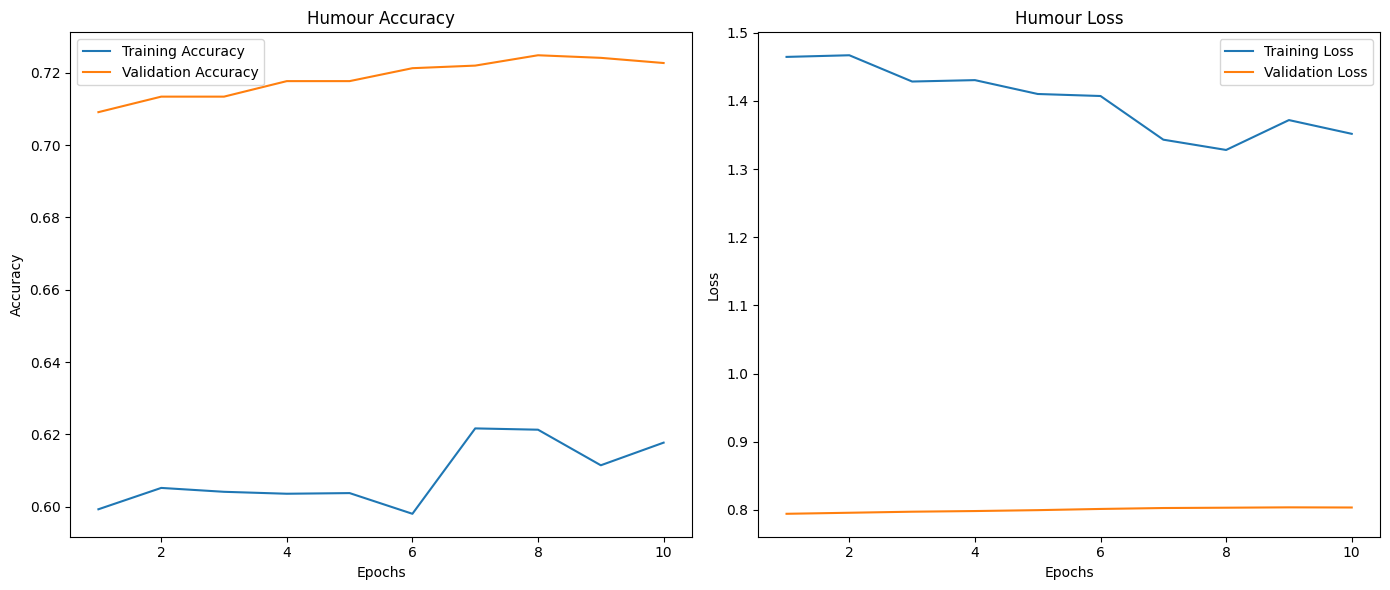


------------------------------------------------------------------------------
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step
Humour - Precision: 0.7632, Recall: 0.9177, F1-score: 0.8333


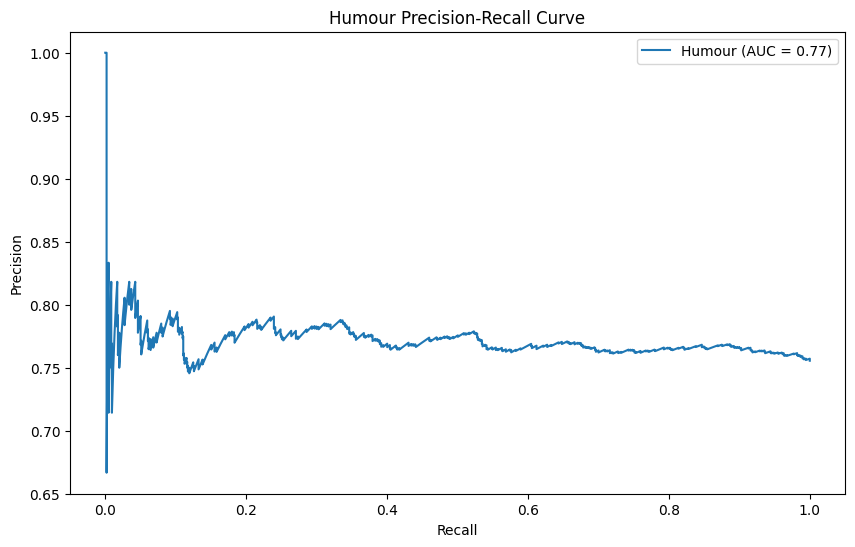

In [120]:
print("--------------------------Training of humour model --------------------------")
history_humour = train_model(
    model_humour,
    [X_train_indices, image_encodings_train],
    Y_humour_train_onehot,
    [X_val_indices, image_encodings_val],
    Y_humour_val_onehot,
    epochs = 10,
    checkpoint_file='content/humour_checkpoint.weights.h5'
)

print("\n------------------------------------------------------------------------------")
print("Evaluation loss and accuracy for humour model")
evaluate_model(model_humour, [X_val_indices, image_encodings_val], Y_humour_val_onehot)
print("\n------------------------------------------------------------------------------")

# Plots for training histories
plot_training_history(history_humour, 'Humour')
print("\n------------------------------------------------------------------------------")

# Evaluate models
evaluate_classification_performance(model_humour, [X_val_indices, image_encodings_val], Y_humour_val_onehot, 'Humour')

#### Sarcasm Sentiment Model

--------------------------Training of sarcasm model --------------------------
Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 285ms/step - accuracy: 0.3931 - loss: 2.2286 - val_accuracy: 0.5947 - val_loss: 0.8109
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 301ms/step - accuracy: 0.5833 - loss: 1.1585 - val_accuracy: 0.7241 - val_loss: 0.6657
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 285ms/step - accuracy: 0.6471 - loss: 0.9457 - val_accuracy: 0.7505 - val_loss: 0.6608
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 279ms/step - accuracy: 0.6615 - loss: 0.9525 - val_accuracy: 0.7484 - val_loss: 0.6398
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 294ms/step - accuracy: 0.6532 - loss: 0.8963 - val_accuracy: 0.7462 - val_loss: 0.6231
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 288ms/step - accuracy: 0.6706 - loss: 0.8108 - val_accuracy: 0.7491 - val_loss: 0.6101
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 294ms/step - accuracy: 0.6708 - loss: 0.8079 - val_accuracy: 0.7513 - val_loss: 0.6002
Epoch 8/10
28/28 ━━━━━━━━

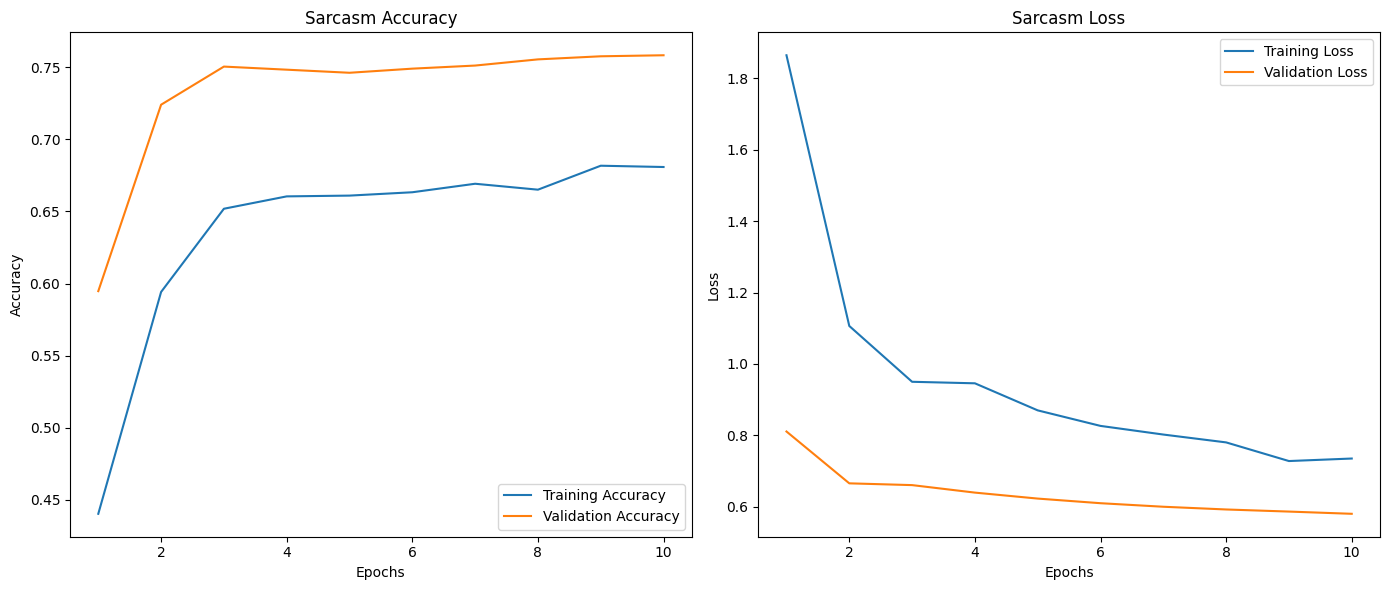


------------------------------------------------------------------------------
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


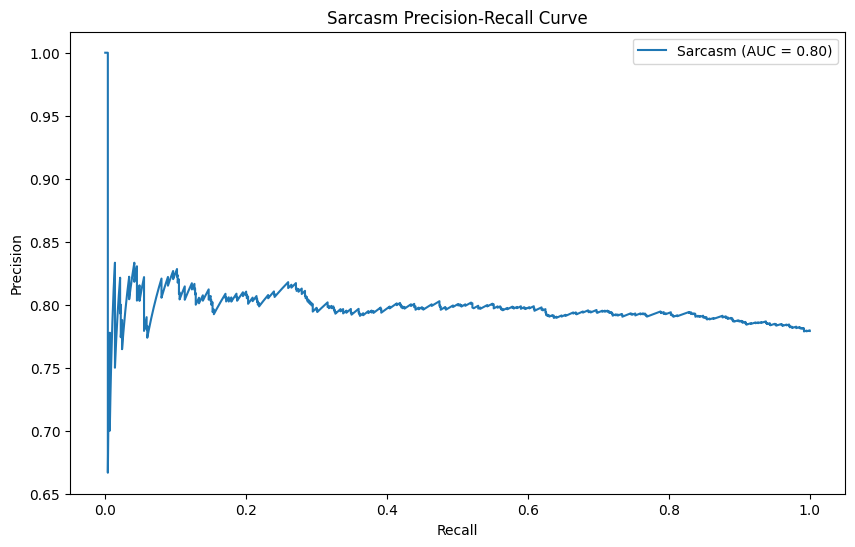

In [75]:
print("--------------------------Training of sarcasm model --------------------------")
history_sarcasm = train_model(
    model_sarcasm,
    [X_train_indices, image_encodings_train],
    Y_sarcasm_train_onehot,
    [X_val_indices, image_encodings_val],
    Y_sarcasm_val_onehot,
    epochs=10,
    checkpoint_file='content/sarcasm_checkpoint.weights.h5'
)
print("\n------------------------------------------------------------------------------")
print("Evaluation loss and accuracy for sarcasm model")
evaluate_model(model_sarcasm, [X_val_indices, image_encodings_val], Y_sarcasm_val_onehot)
print("\n------------------------------------------------------------------------------")

# Plots for training histories
plot_training_history(history_sarcasm, 'Sarcasm')
print("\n------------------------------------------------------------------------------")

# Evaluate models
evaluate_classification_performance(model_sarcasm, [X_val_indices, image_encodings_val], Y_sarcasm_val_onehot, 'Sarcasm')

#### Offensive Sentiment Model

--------------------------Training of offensive model --------------------------
Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 276ms/step - accuracy: 0.4794 - loss: 2.0061 - val_accuracy: 0.4839 - val_loss: 1.0535
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 273ms/step - accuracy: 0.4965 - loss: 1.8511 - val_accuracy: 0.4968 - val_loss: 1.0113
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 272ms/step - accuracy: 0.5087 - loss: 1.8350 - val_accuracy: 0.5068 - val_loss: 0.9839
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 293ms/step - accuracy: 0.5024 - loss: 1.7658 - val_accuracy: 0.5082 - val_loss: 0.9668
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 284ms/step - accuracy: 0.4945 - loss: 1.7922 - val_accuracy: 0.5139 - val_loss: 0.9556
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 289ms/step - accuracy: 0.5066 - loss: 1.7277 - val_accuracy: 0.5232 - val_loss: 0.9485
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 277ms/step - accuracy: 0.5145 - loss: 1.6785 - val_accuracy: 0.5275 - val_loss: 0.9445
Epoch 8/10
28/28 ━━━━━━

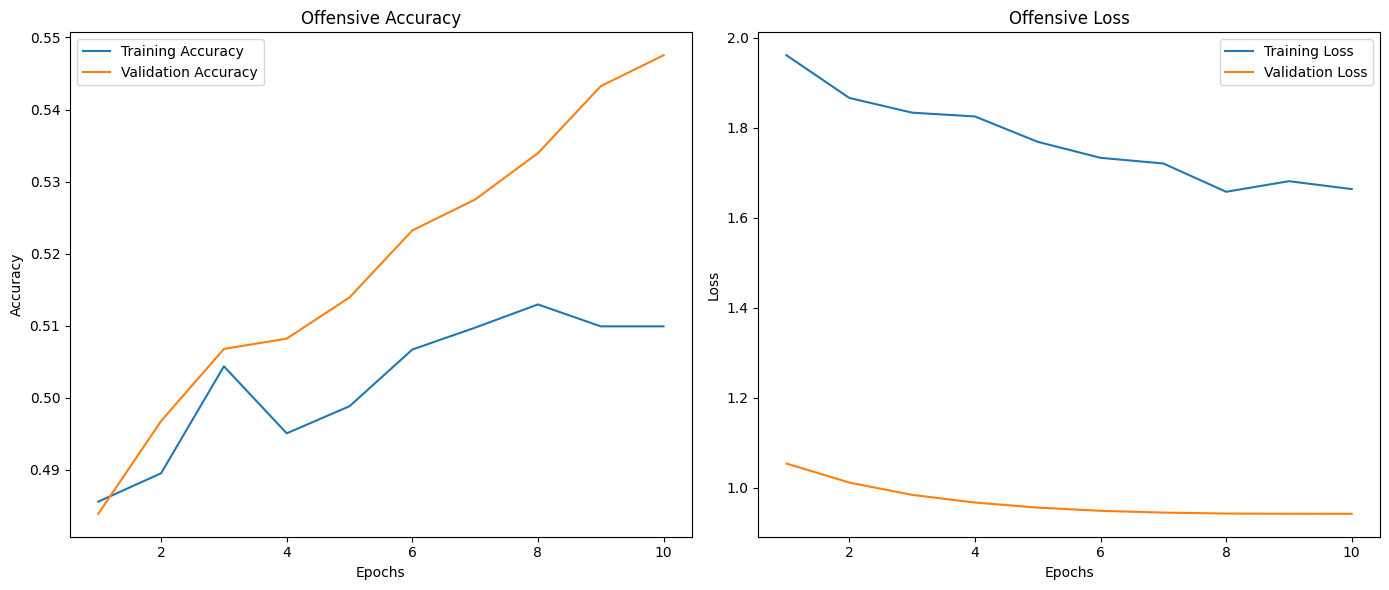


------------------------------------------------------------------------------
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Offensive - Precision: 0.6022, Recall: 0.7153, F1-score: 0.6539


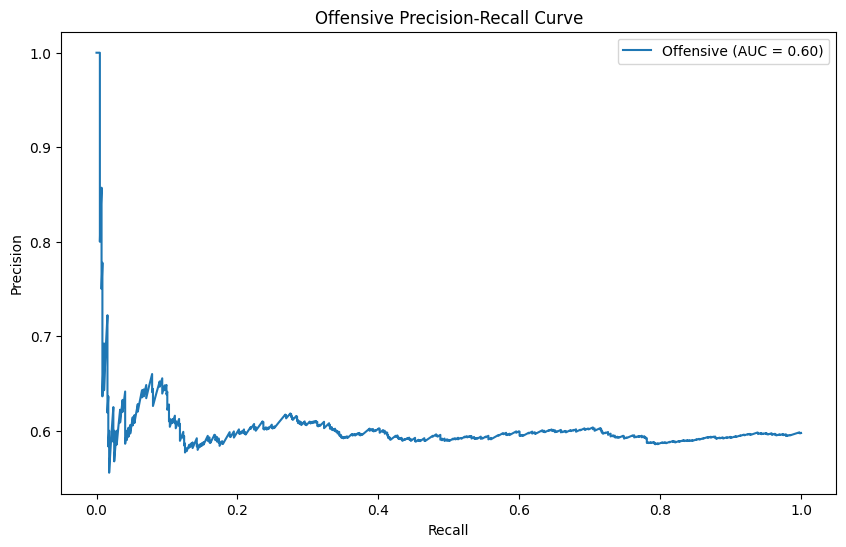

In [119]:
print("--------------------------Training of offensive model --------------------------")
history_offensive = train_model(
    model_offensive,
    [X_train_indices, image_encodings_train],
    Y_offensive_train_onehot,
    [X_val_indices, image_encodings_val],
    Y_offensive_val_onehot,
    epochs = 10,
    checkpoint_file='content/offensive_checkpoint.weights.h5'
)
print("\n------------------------------------------------------------------------------")
print("Evaluation loss and accuracy of offensive model")
evaluate_model(model_offensive, [X_val_indices, image_encodings_val], Y_offensive_val_onehot)
print("\n------------------------------------------------------------------------------")

# Plots for training histories
plot_training_history(history_offensive, 'Offensive')
print("\n------------------------------------------------------------------------------")

# Evaluate models
evaluate_classification_performance(model_offensive, [X_val_indices, image_encodings_val], Y_offensive_val_onehot, 'Offensive')

#### Motivation Sentiment Model

--------------------------Training of motivate model --------------------------
Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 275ms/step - accuracy: 0.5679 - loss: 0.7857 - val_accuracy: 0.5976 - val_loss: 0.6902
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 275ms/step - accuracy: 0.5763 - loss: 0.7508 - val_accuracy: 0.6076 - val_loss: 0.6817
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 273ms/step - accuracy: 0.5751 - loss: 0.7446 - val_accuracy: 0.6126 - val_loss: 0.6763
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 271ms/step - accuracy: 0.5919 - loss: 0.7191 - val_accuracy: 0.6190 - val_loss: 0.6729
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 273ms/step - accuracy: 0.5929 - loss: 0.7151 - val_accuracy: 0.6226 - val_loss: 0.6694
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 283ms/step - accuracy: 0.5930 - loss: 0.7024 - val_accuracy: 0.6283 - val_loss: 0.6658
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 293ms/step - accuracy: 0.5906 - loss: 0.6983 - val_accuracy: 0.6319 - val_loss: 0.6643
Epoch 8/10
28/28 ━━━━━━━

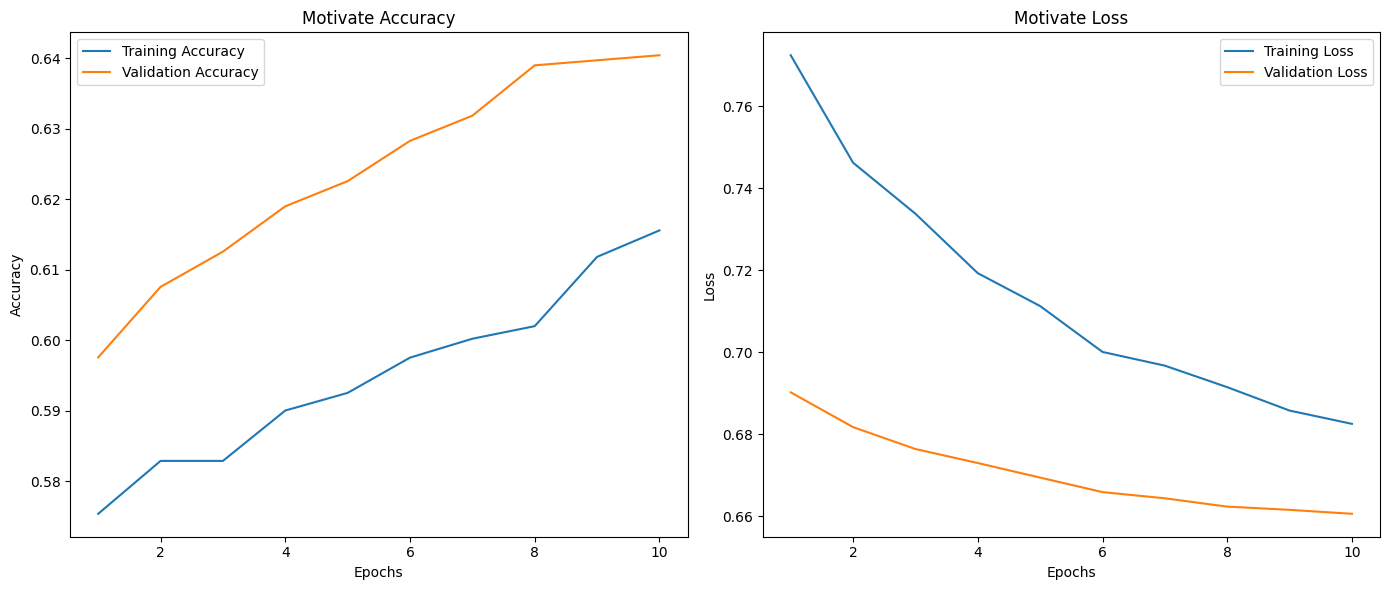


------------------------------------------------------------------------------


In [118]:
print("--------------------------Training of motivate model --------------------------")
history_motivate = train_model(
    model_motivate,
    [X_train_indices, image_encodings_train],
    Y_motivate_train_onehot,
    [X_val_indices, image_encodings_val],
    Y_motivate_val_onehot,
    epochs = 10,
    checkpoint_file='content/motivate_checkpoint.weights.h5'
)
print("\n------------------------------------------------------------------------------")
print("Evaluation loss and accuracy of motivate model")
evaluate_model(model_motivate, [X_val_indices, image_encodings_val], Y_motivate_val_onehot)
print("\n------------------------------------------------------------------------------")

# Plots for training histories
plot_training_history(history_motivate, 'Motivate')
print("\n------------------------------------------------------------------------------")



#### Overall Sentiment Model

--------------------------Training of overall sentiment model --------------------------
Epoch 1/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 289ms/step - accuracy: 0.7457 - loss: 0.8395 - val_accuracy: 0.8227 - val_loss: 0.5907
Epoch 2/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 287ms/step - accuracy: 0.7448 - loss: 0.8805 - val_accuracy: 0.8292 - val_loss: 0.5885
Epoch 3/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 284ms/step - accuracy: 0.7496 - loss: 0.8364 - val_accuracy: 0.8320 - val_loss: 0.5870
Epoch 4/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 279ms/step - accuracy: 0.7595 - loss: 0.7941 - val_accuracy: 0.8370 - val_loss: 0.5861
Epoch 5/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 283ms/step - accuracy: 0.7654 - loss: 0.8173 - val_accuracy: 0.8420 - val_loss: 0.5857
Epoch 6/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 272ms/step - accuracy: 0.7708 - loss: 0.7771 - val_accuracy: 0.8477 - val_loss: 0.5858
Epoch 7/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 275ms/step - accuracy: 0.7747 - loss: 0.8011 - val_accuracy: 0.8499 - val_loss: 0.5861
Epoch 8/15
28/2

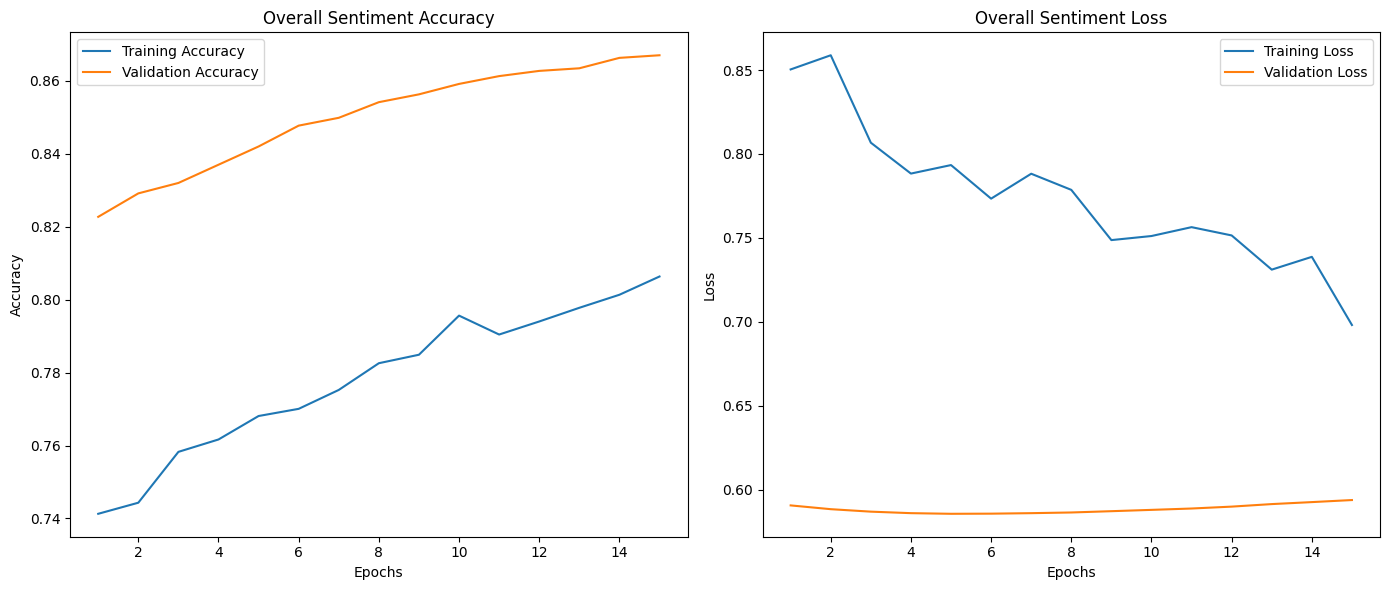


------------------------------------------------------------------------------


In [100]:
print("--------------------------Training of overall sentiment model --------------------------")
history_overall_sentiment = train_model(
    model_overall_sentiment,
    [X_train_indices, image_encodings_train],
    Y_overall_train_onehot,
    [X_val_indices, image_encodings_val],
    Y_overall_val_onehot,
    epochs=15,
    checkpoint_file='content/sentiment_checkpoint3.weights.h5'
)
print("\n------------------------------------------------------------------------------")
print("Evaluation loss and accuracy of overall sentiment model")
evaluate_model(model_overall_sentiment, [X_val_indices, image_encodings_val], Y_overall_val_onehot)
print("\n------------------------------------------------------------------------------")

# Plots for training histories
plot_training_history(history_overall_sentiment, 'Overall Sentiment')
print("\n------------------------------------------------------------------------------")

In [128]:
# Saving weights of models
model_names = ['overall_sentiment', 'humour', 'sarcasm', 'offensive', 'motivate']
models = [model_overall_sentiment, model_humour, model_sarcasm, model_offensive, model_motivate]

for model, name in zip(models, model_names):
    weight_path = f'/Users/praharshmedisetty/Documents/Visual_Studio/content/{name}.weights.h5'
    model.save_weights(weight_path)
    print(f"Weights for {name} saved at {weight_path}")

Weights for overall_sentiment saved at /Users/praharshmedisetty/Documents/Visual_Studio/content/overall_sentiment.weights.h5
Weights for humour saved at /Users/praharshmedisetty/Documents/Visual_Studio/content/humour.weights.h5
Weights for sarcasm saved at /Users/praharshmedisetty/Documents/Visual_Studio/content/sarcasm.weights.h5
Weights for offensive saved at /Users/praharshmedisetty/Documents/Visual_Studio/content/offensive.weights.h5
Weights for motivate saved at /Users/praharshmedisetty/Documents/Visual_Studio/content/motivate.weights.h5
